# X-Inactivation Sex Differences DV Analysis

Detection of X-inactivation via differential variance

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import scipy.sparse as sparse
import seaborn as sns
import imp
import time
from statsmodels.stats.multitest import fdrcorrection

In [110]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [111]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/x_inactivation_data/'

### Save some metadata from the Lupus AnnData object

In [114]:
full_adata = sc.read(data_path + 'lupus_annotated_nonorm_V6_x_genes.h5ad')

In [131]:
# Sample the females
sampled_females = np.random.choice(
    full_adata.obs\
        .query('Female == 1.0 & disease_cov == "sle"')\
        .ind_cov\
        .drop_duplicates()\
        .tolist(),
    14).tolist()

males = \
    full_adata.obs\
    .query('Female == 0.0 & disease_cov == "sle"')\
    .ind_cov\
    .drop_duplicates()\
    .tolist()

df = pd.DataFrame()
df['ind_cov'] = sampled_females + males
df.to_csv(data_path + 'lupus_sampled_ind_list.csv', index=False)

### Read cell type and individual information

In [116]:
ct_list = pd.read_csv(data_path + 'lupus_ct_list.csv')['ct_cov'].tolist()

In [117]:
len(ct_list)

12

In [118]:
ind_list = pd.read_csv(data_path + 'lupus_ind_list.csv')
males = set(ind_list.query('Female == 0.0').ind_cov)
females = set(ind_list.query('Female == 1.0').ind_cov)

### Read DE and DV results

The results are computed in the `compute_x_inactivation_statistics.py` script in the Wynton cluster.

In [119]:
de_pval = pd.DataFrame(
    data=np.vstack([np.load(data_path + 'sex_statistics/{}_de_pvals.npy'.format(ct)) for ct in ct_list]),
    index=ct_list,
    columns=full_adata.var.index.values).T

dv_pval = pd.DataFrame(
    data=np.vstack([np.load(data_path + 'sex_statistics/{}_dv_pvals.npy'.format(ct)) for ct in ct_list]),
    index=ct_list,
    columns=full_adata.var.index.values).T

### Perform FDR correction

In [120]:
def fdr_correct_df(df):
    
    _df = df.copy()
    
    for col in df.columns:
        
        pvals = df[col].values
        fdr = np.full_like(pvals, np.nan, dtype=np.double)
        _, fdr[~np.isnan(pvals)] = fdrcorrection(pvals[~np.isnan(pvals)], alpha=0.1)
        _df[col] = fdr
    return _df

In [121]:
de_fdr = fdr_correct_df(de_pval)
dv_fdr = fdr_correct_df(dv_pval)

In [122]:
sig_threshold = 0.1
de_sig = (de_fdr < sig_threshold)
dv_sig = (dv_fdr < sig_threshold)

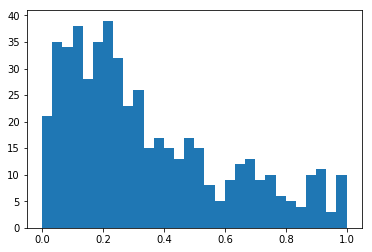

In [124]:
plt.hist(de_pval['Tc'][~np.isnan(de_pval['Tc'])], bins=30);

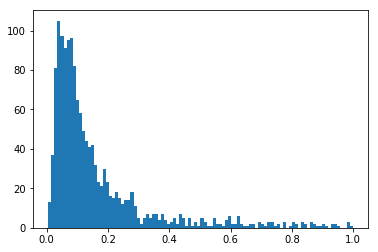

In [17]:
plt.hist(dv_pval['Tc'][~np.isnan(dv_pval['Tc'])], bins=100);

In [125]:
tc_null = np.load(data_path + 'sex_statistics/Tc_dv_null_t_stats.npy')
tc_t = np.load(data_path + 'sex_statistics/Tc_dv_t_stats.npy')

In [126]:
np.nanmax(tc_t)

43.20853553891396

(0, 0.1)

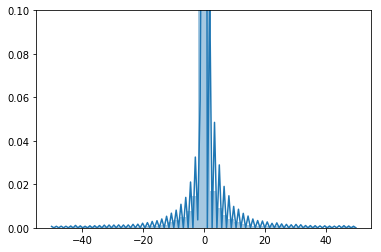

In [127]:
sns.distplot(tc_null[np.absolute(tc_null) < 50], bins=50);
#sns.distplot(tc_t[np.absolute(tc_t) < 50], bins=50);

plt.ylim(0, 0.1)

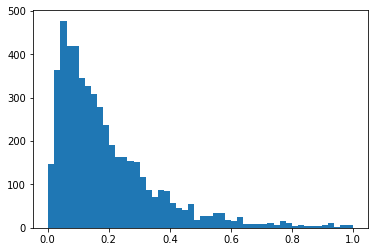

In [128]:
plt.hist(dv_pval.values.reshape(-1)[~np.isnan(dv_pval.values.reshape(-1))], bins=50);

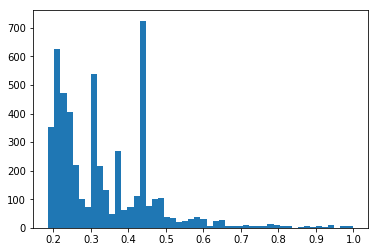

In [129]:
plt.hist(dv_fdr.values.reshape(-1)[~np.isnan(dv_fdr.values.reshape(-1))], bins=50);

In [130]:
dv_fdr.head(5)

,Tc,Th,cM,NK,B,ncM,pDC,MK,DB,cDC,ProlifT,Progen
GRPR,NaN,NaN,0.310514,NaN,0.281873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGAG4,0.216651,0.321279,0.203794,0.244024,0.225381,0.319105,NaN,NaN,0.310448,0.392530,NaN,NaN
BRS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRAPPC2,0.206419,0.255305,0.186326,0.243760,0.311791,0.335970,0.440925,0.321041,0.310448,0.392075,0.434882,0.435116
ASB9,0.206419,0.235557,0.186326,NaN,NaN,0.307232,NaN,NaN,NaN,0.600879,0.434882,0.470955


### Count significant and insignificant genes

In [48]:
sig_counts = {}
for ct in ct_list:
    
    df = pd.DataFrame(index=de_fdr[ct].index)
    
    ct_inds = set(de_fdr[ct].columns.values)
    
    df['male_dv_sig'] = dv_fdr[ct][list(males & ct_inds)].apply(lambda x: x < 0.01).sum(axis=1)
    df['male_dv_insig'] = dv_fdr[ct][list(males & ct_inds)].shape[1] - df['male_dv_sig'].values
    
    df['female_dv_sig'] = dv_fdr[ct][list(females & ct_inds)].apply(lambda x: x < 0.01).sum(axis=1)
    df['female_dv_insig'] = dv_fdr[ct][list(females & ct_inds)].shape[1] - df['female_dv_sig'].values
    
    df['male_sig_proportion'] =  df['male_dv_sig'] / (df['male_dv_sig'] + df['male_dv_insig'])
    df['female_sig_proportion'] =  df['female_dv_sig'] / (df['female_dv_sig'] + df['female_dv_insig'])
    
    sig_counts[ct] = df.copy()

### Perform Fischer's exact test for each gene

In [49]:
gene_info = pd.read_csv(data_path + '../misc/my_uscs_ids_symbols.map.bed', sep='\t', header=None)[[0, 5]].drop_duplicates()
gene_info.columns=['chr', 'gene']
gene_info = gene_info.set_index('gene')

In [50]:
def get_fisher_pval(row):
    
    contingency = [[row['male_dv_sig'], row['male_dv_insig']], [row['female_dv_sig'], row['female_dv_insig']]]
    
    return stats.fisher_exact(contingency)[1]

In [51]:
for ct in ct_list:
    
    print('Computing fisher pval for cell type {}'.format(ct))
    sig_counts[ct]['fisher_pval'] = sig_counts[ct].apply(get_fisher_pval, axis=1)
    _, sig_counts[ct]['fisher_fdr'] = fdrcorrection(sig_counts[ct]['fisher_pval'])
    
    sig_counts[ct] = sig_counts[ct].join(gene_info, how='left')

Computing fisher pval for cell type Tc
Computing fisher pval for cell type Th
Computing fisher pval for cell type cM
Computing fisher pval for cell type NK
Computing fisher pval for cell type B
Computing fisher pval for cell type ncM
Computing fisher pval for cell type pDC
Computing fisher pval for cell type MK
Computing fisher pval for cell type DB
Computing fisher pval for cell type cDC
Computing fisher pval for cell type ProlifT
Computing fisher pval for cell type Progen


### Get chromosome

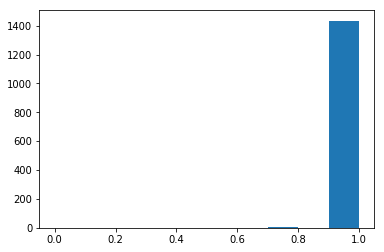

In [132]:
plt.hist(sig_counts['Th'].fisher_fdr);

In [134]:
sig_counts['Tc'].query('fisher_fdr < 0.1')

,male_dv_sig,male_dv_insig,female_dv_sig,female_dv_insig,male_sig_proportion,female_sig_proportion,fisher_pval,fisher_fdr,chr
DDX3Y,1,13,99,56,0.071429,0.638710,3.931193e-05,1.155506e-02,chrY
EIF1AY,1,13,110,45,0.071429,0.709677,3.524787e-06,1.696598e-03,chrY
MARCH3,7,7,9,146,0.500000,0.058065,4.001060e-05,1.155506e-02,chr5
TTTY15,1,13,131,24,0.071429,0.845161,4.658668e-09,3.363558e-06,chrY
UTY,0,14,130,25,0.000000,0.838710,1.475245e-10,2.130254e-07,chrY
ZNF578,7,7,13,142,0.500000,0.083871,2.304544e-04,5.546269e-02,chr19
